## About the final project

The rate of fake news spread has grown beyond the limits of manual moderation and warrants an automated flagging or filtering approach. Here we explore the applicability of several common machine-learning algorithms for automatically detecting a fake news story based on its content.

Using standard natural language processing methods we converted ~20,000 real news stories and ~20,000 fake news stories from [a pre-made dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) into vectors. We then implemented, tuned, trained, and tested five classifiers: Naive Bayes Gaussian, naive Bayes multinomial, K-nearest-neighbors, decision tree, and random forest. Using a 75/25% train/test split of our data, we calculated and compared the accuracy, precision, recall, and F1-scores of the five models.

# I. Imports, preprocessing, and data exploration

## Imports

In [41]:
# importing, reading, and combining data
import numpy as np 
import pandas as pd
import ast

# sklearn
import sklearn

# natural language processing
import spacy
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# figures and visualization
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix

# classifiers and testing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# misc
import time
import operator
from IPython.display import clear_output

# notebook magic
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data aggregatation and preprocessing

In [2]:
# set the data path
data_path = 'C:/Git_repos/fake_news_detection/raw_data/'

# set the figure path
figure_path = 'C:/Git_repos/fake_news_detection/figures/'

# open the fake and real datasets
raw_real_df = pd.read_csv(data_path + 'True.csv')
raw_fake_df = pd.read_csv(data_path + 'Fake.csv')


# add a label column to each dataset (1 = "real", 0 = "false")
real_news_df = raw_real_df[['title', 'text', 'subject', 'date']]
real_news_df['label'] = "real"

fake_news_df = raw_fake_df[['title', 'text', 'subject', 'date']]
fake_news_df['label'] = "fake"

# view a preview of the dataset
fake_news_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


## Language cleaning

### Get stopwords


In [3]:
# load spacy library
nlp = spacy.load("en_core_web_sm")

# create instance of the lemmatizer
lemma = WordNetLemmatizer()

# get stopword lists from both spacy and nltk
spacy_stop_words = nlp.Defaults.stop_words
nltk_stop_words = stopwords.words('english')

# make a combined list of all unique stop words
all_stopwords = set((set(spacy_stop_words)|set(nltk_stop_words)))

print("Using {} stopwords.".format(len(all_stopwords)))

Using 382 stopwords.


Lemmatization and stopword removal

In [4]:
# define a text cleaning function
def clean_text(text):

    # create an empty string
    string = ""
    
    # make all text lower-case
    text=text.lower()
    
    # remove identifying tags
    text = re.sub(r"reuters", "", text)
    
    # remove url phrases
    text = re.sub(r"www", "", text)

    # remove common special characters
    text = re.sub(r"[-()\"#!@$%^&*{}?.,:]", " ", text)
    
    # remove any non alphabet characters
    text = re.sub("[^a-z]+", " ", text)
    
    # loop through each word in the text
    for word in text.split():

        # ignore the stop words
        if word not in all_stopwords:

            # lemmatize the word, add it to the cleaned string
            string += lemma.lemmatize(word) + " "
    
    # return the lemmatized text as a string
    return string

The code above is extremely ineffcient due to the number of records, number of words, and the number of checks for  substitutions and stopword checks that must be applied. Avoid re-running the cell below.

In [5]:
# clean the dataframes by applying the clean function
fake_news_df['text_clean'] = fake_news_df['text'].apply(clean_text)
fake_news_df['title_clean'] = fake_news_df['title'].apply(clean_text)
real_news_df['text_clean'] = real_news_df['text'].apply(clean_text)
real_news_df['title_clean'] = real_news_df['title'].apply(clean_text)

## Data exploration

### Data balance

In [6]:
# check the imbalance
precent_fake = round(100 * len(fake_news_df) / (len(fake_news_df) + len(real_news_df)))
percent_real = round(100 * len(real_news_df) / (len(fake_news_df) + len(real_news_df)))
excess_fake = len(fake_news_df)-len(real_news_df)

print("The dataset has a balance of {}%/{}%, with {} excess fake news stories.".format(precent_fake, percent_real, excess_fake))

The dataset has a balance of 52%/48%, with 2064 excess fake news stories.


In [7]:
# randomly subsample the data and to remove the excess fake news stories
sample_fraction = 1 - (excess_fake/len(fake_news_df))
fake_news_df = fake_news_df.sample(frac=sample_fraction).reset_index(drop=True)

In [8]:
# check to make sure the balancing worked
precent_fake = round(100 * len(fake_news_df) / (len(fake_news_df) + len(real_news_df)))
percent_real = round(100 * len(real_news_df) / (len(fake_news_df) + len(real_news_df)))

print("The dataset now has a balance of {}%/{}% with {} total records.".format(precent_fake, percent_real, len(fake_news_df)+len(real_news_df)))

The dataset now has a balance of 50%/50% with 42834 total records.


### Word clouds

In [9]:
# make a function to generate wordclouds
# plt_x, plt_y are plt sizes; wc_x, wc_y are pixel dimensions
def generate_word_cloud(plt_x, plt_y, wc_x, wc_y, wc_max_words, dataframe, savename):
  
  # set the figure size
  plt.figure(figsize = (plt_x, plt_y), tight_layout=True)

  # generate the word cloud
  word_cloud = WordCloud(max_words = wc_max_words , width = wc_x , height = wc_y).generate(" ".join(dataframe))

  # hide the axes
  plt.axis("off")

  # show the plot
  plt.imshow(word_cloud , interpolation = "bilinear")

  plt.savefig(figure_path + savename, dpi = (wc_x/plt_x))

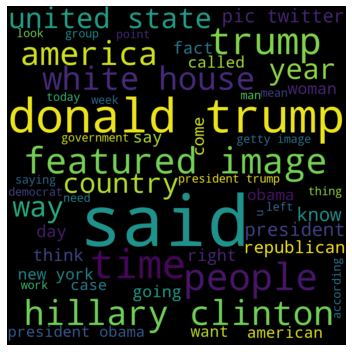

In [10]:
# generate a fake news article word cloud
generate_word_cloud(5, 5, 1000, 1000, 50, fake_news_df['text_clean'], "text_fake.png")

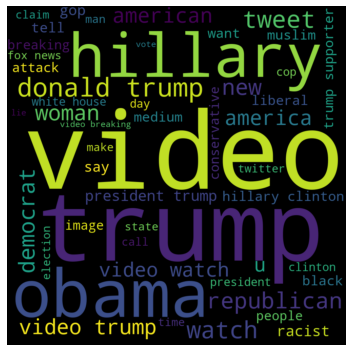

In [11]:
# generate a fake news title word cloud
generate_word_cloud(5, 5, 1000, 1000, 50, fake_news_df['title_clean'], "title_fake.png")

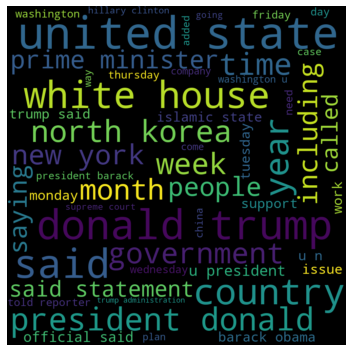

In [12]:
# generate a real news article word cloud
generate_word_cloud(5, 5, 1000, 1000, 50, real_news_df['text_clean'], "text_true.png")

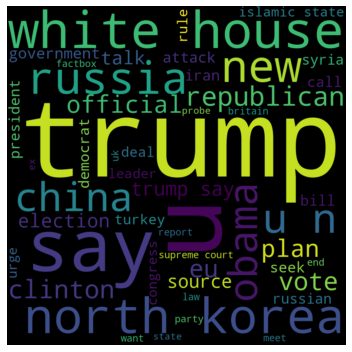

In [13]:
# generate a real news title word cloud
generate_word_cloud(5, 5, 1000, 1000, 50, real_news_df['title_clean'], "title_true.png")

# II. Data conversion

## Convert text to vectors

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [14]:
# combine the dataframes 
all_news_df = pd.concat([real_news_df, fake_news_df])

# save the data as a backup
all_news_df.to_csv(data_path + 'all_news_with_cleaned.csv')

all_news_df.head()

,title,text,subject,date,label,text_clean,title_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",real,washington head conservative republican factio...,u budget fight loom republican flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",real,washington transgender people allowed time enl...,u military accept transgender recruit monday p...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",real,washington special counsel investigation link ...,senior u republican senator let mr mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",real,washington trump campaign adviser george papad...,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",real,seattle washington president donald trump call...,trump want postal service charge amazon shipment


In [15]:
# generate converter for changing text to vectors 
# TfidfVectorizer(max_features= number of words to find, min_df= minimum fraction of occurance, max_df= maximum fraction of occurance)
TFIDF_converter = TfidfVectorizer(max_features=1000, min_df=0.1, max_df=0.8)

# apply the converter and make a dataframe
all_text_vectors = TFIDF_converter.fit_transform(all_news_df['text_clean'])

In [16]:
# convert the vectors to a dataframe
all_text_vectors_df = pd.DataFrame(all_text_vectors.toarray(), columns = TFIDF_converter.get_feature_names())

# add the labels back from the orignal dataframe
all_text_vectors_df.insert(0, "classification_label", all_news_df["label"].tolist())

# check the new dataframe
all_text_vectors_df.head()

,classification_label,according,act,action,added,administration,agency,america,american,anti,...,way,wednesday,week,white,woman,work,working,world,year,york
0,real,0.000000,0.0,0.051216,0.0,0.091606,0.000000,0.0,0.000000,0.0,...,0.041114,0.092542,0.000000,0.040448,0.0,0.045634,0.0,0.000000,0.090971,0.000000
1,real,0.000000,0.0,0.000000,0.0,0.485609,0.000000,0.0,0.040145,0.0,...,0.043589,0.000000,0.082060,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,real,0.000000,0.0,0.000000,0.0,0.107504,0.000000,0.0,0.000000,0.0,...,0.096498,0.000000,0.090833,0.047468,0.0,0.000000,0.0,0.000000,0.035586,0.120649
3,real,0.064523,0.0,0.078024,0.0,0.000000,0.000000,0.0,0.057684,0.0,...,0.000000,0.000000,0.000000,0.184859,0.0,0.000000,0.0,0.000000,0.046196,0.234928
4,real,0.147559,0.0,0.000000,0.0,0.000000,0.071074,0.0,0.026384,0.0,...,0.000000,0.000000,0.000000,0.028184,0.0,0.000000,0.0,0.032039,0.126776,0.000000


In [17]:
# save the data as a backup
all_text_vectors_df.to_csv(data_path + 'all_text_vectors.csv')

## Train-test split the data

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [18]:
# split into train and test
text_vectors_train, text_vectors_test, label_train, label_test = train_test_split(all_text_vectors_df.loc[:, all_text_vectors_df.columns != 'classification_label'], 
                                                                                  all_text_vectors_df['classification_label'], test_size=0.25, random_state=42)

# check to make sure the splits worked
print("Text data test fraction: {}%".format(round(len(text_vectors_test)/(len(text_vectors_test) + len(text_vectors_train))*100)))

Text data test fraction: 25%


# III. Model generation


## Naive Bayes classifiers
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

NB are typically O(nK) in complexity, where K is the number of classes

### Gaussian naive Bayes

In [19]:
# initialize the Guassian nb model
gnb_model = GaussianNB()

# mark the start time
start_time = time.time()

# fit the model to the training data
gnb_model.fit(text_vectors_train, label_train)

# apply the model to the test data
gnb_model_predict = gnb_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
gnb_model_time = round(end_time - start_time, 3)

# get the results
gnb_results = classification_report(label_test, gnb_model_predict)
gnb_dict_results = classification_report(label_test, gnb_model_predict, output_dict=True)

# print results
print(str(gnb_model_time) + "s to process")
print(gnb_results)

0.312s to process
              precision    recall  f1-score   support

        fake       0.89      0.83      0.86      5322
        real       0.85      0.90      0.87      5387

    accuracy                           0.87     10709
   macro avg       0.87      0.87      0.87     10709
weighted avg       0.87      0.87      0.87     10709



### Check for overfitting

In [20]:
training_score = gnb_model.score(text_vectors_train, label_train)
print("training score: {}".format(training_score))

test_score = gnb_model.score(text_vectors_test, label_test)
print("testing score: {}".format(test_score))

training score: 0.8717198443579767
testing score: 0.868988701092539


### Multinomial naive Bayes

In [21]:
# initialize the multinomial nb model
mnb_model = MultinomialNB()

# mark the start time
start_time = time.time()

# fit the model to the training data
mnb_model.fit(text_vectors_train, label_train)

# apply the model to the test data
mnb_model_predict = mnb_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
mnb_model_time = round(end_time - start_time, 3)

# get the results
mnb_results = classification_report(label_test, mnb_model_predict)
mnb_dict_results = classification_report(label_test, mnb_model_predict, output_dict=True)

# print the results
print(str(mnb_model_time) + "s to process")
print(mnb_results)

0.157s to process
              precision    recall  f1-score   support

        fake       0.92      0.88      0.90      5322
        real       0.88      0.92      0.90      5387

    accuracy                           0.90     10709
   macro avg       0.90      0.90      0.90     10709
weighted avg       0.90      0.90      0.90     10709



### Check for overfitting

In [22]:
training_score = mnb_model.score(text_vectors_train, label_train)
print("training score: {}".format(training_score))

test_score = mnb_model.score(text_vectors_test, label_test)
print("testing score: {}".format(test_score))

training score: 0.9004824902723736
testing score: 0.8984032122513773


## Custom grid search function

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [23]:
# define a function that performs a grid search
def fake_news_grid_search(estimator, parameter_grid):
  
  # mark the start of the tuning process  
  start_time = time.time()

  # initalize the grid search
  grid_search = GridSearchCV(estimator, parameter_grid, n_jobs=-1)

  # apply the grid search to the training data
  grid_search_application = grid_search.fit(text_vectors_train, label_train, cv=3)

  # mark the end of the tuning process
  end_time = time.time()

  # print the elapsed time
  print("Time elapsed: {}".format(end_time - start_time))

  # return the best parameters
  return(grid_search_application.best_params_)

## K-nearest-neighbors classifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

KNN are typically O(n) in complexity

### Tune KNN (run once)



In [24]:
# # set the parameters to tune
# parameter_grid = {'weights': ['uniform', 'distance'],
#                   'p': [1, 2]}

# # return the best parameters
# knn_parameters = fake_news_grid_search(KNeighborsClassifier(n_neighbors=2), parameter_grid)

# # save the best parameters
# output = open(data_path + "knn_optimum_parameters.txt", "w")
# output.write(str(knn_parameters))
# output.close()

### Apply KNN classifier

In [25]:
# load the saved optimum hyperparameters
file = open(data_path + 'knn_optimum_parameters.txt', "r")
contents = file.read()

# convert the string to a dictionary
knn_parameters = ast.literal_eval(contents)
file.close()

# mark the start time
start_time = time.time()

# initialize the knn model, brute is the best algorithm for high-dimensional data
knn_model = KNeighborsClassifier(n_neighbors=2, 
                                 algorithm='brute',
                                 weights=knn_parameters['weights'], 
                                 p=knn_parameters['p'],
                                 n_jobs=1)

# fit the model to the training data
knn_model.fit(text_vectors_train, label_train)

# apply the model to the test data
knn_model_predict = knn_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
knn_model_time = round(end_time - start_time, 3)

# get the results
knn_results = classification_report(label_test, knn_model_predict)
knn_dict_results = classification_report(label_test, knn_model_predict, output_dict=True)

# print the results and parameters
print("parameters:", knn_parameters)
print(str(knn_model_time) + "s to process")
print(knn_results)

parameters: {'p': 1, 'weights': 'uniform'}
99.909s to process
              precision    recall  f1-score   support

        fake       0.73      0.98      0.84      5322
        real       0.97      0.65      0.78      5387

    accuracy                           0.81     10709
   macro avg       0.85      0.82      0.81     10709
weighted avg       0.85      0.81      0.81     10709



### Check for overfitting

In [26]:
training_score = knn_model.score(text_vectors_train, label_train)
print("training score: {}".format(training_score))

test_score = knn_model.score(text_vectors_test, label_test)
print("testing score: {}".format(test_score))

training score: 0.8956264591439689
testing score: 0.8145485105985619


## Decision tree classifier

https://sckit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

DT are typically O(m n log(n)) in complexity, where m is the number of features

### Tune DT (run once)

In [27]:
# # set the parameters to tune
# parameter_grid =  {'max_features': ["auto", "sqrt", "log2"],
#                   'max_depth': [5, 10, 20, 30, 40],
#                   'min_samples_leaf': [2, 4, 6, 8, 10]}

# dt_parameters = fake_news_grid_search(DecisionTreeClassifier(), parameter_grid)

# # save the best parameters
# output = open(data_path + "dt_optimum_parameters.txt", "w")
# output.write(str(dt_parameters))
# output.close()

### Apply DT classifier

In [28]:
# load the saved optimum hyperparameters
file = open(data_path + 'dt_optimum_parameters.txt', "r")
contents = file.read()

# convert the string to a dictionary
dt_parameters = ast.literal_eval(contents)
file.close()

# mark the start time
start_time = time.time()

# initialize the dt model
dt_model = DecisionTreeClassifier(max_depth=dt_parameters['max_depth'],
                                  min_samples_leaf=dt_parameters['min_samples_leaf'],
                                  max_features=dt_parameters['max_features'])

# fit the model to the training data
dt_model.fit(text_vectors_train, label_train)

# apply the model to the test data
dt_model_predict = dt_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
dt_model_time = round(end_time - start_time, 3)

# get the results
dt_results = classification_report(label_test, dt_model_predict)
dt_dict_results = classification_report(label_test, dt_model_predict, output_dict=True)

# print the results and parameters
print("parameters:", dt_parameters)
print(str(dt_model_time) + "s to process")
print(dt_results)

parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2}
0.328s to process
              precision    recall  f1-score   support

        fake       0.86      0.92      0.89      5322
        real       0.91      0.85      0.88      5387

    accuracy                           0.88     10709
   macro avg       0.89      0.88      0.88     10709
weighted avg       0.89      0.88      0.88     10709



### Check for overfitting

In [29]:
training_score = dt_model.score(text_vectors_train, label_train)
print("training score: {}".format(training_score))

test_score = dt_model.score(text_vectors_test, label_test)
print("testing score: {}".format(test_score))

training score: 0.9696498054474708
testing score: 0.8834625081706975


## Random-forest classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RF are typucally O(M(m n log n) in complexity, where m is the number of features and M the number of trees

### Tune RF (run once)

In [30]:
# # set the parameters to tune
# parameter_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 75, 80, 85],
#                   'max_features': ['auto', 'sqrt', 'log2'],
#                   'max_depth': [5, 10, 15, 20, 25, 30, 40],
#                   'min_samples_leaf': [2, 4, 6, 8, 10]}

# rf_parameters = fake_news_grid_search(RandomForestClassifier(), parameter_grid)

# # save the best parameters
# output = open(data_path + "rf_optimum_parameters.txt", "w")
# output.write(str(rf_parameters))
# output.close()

### Apply RF classifier

In [31]:
# load the saved optimum hyperparameters
file = open(data_path + 'rf_optimum_parameters.txt', "r")
contents = file.read()

# convert the string to a dictionary
rf_parameters = ast.literal_eval(contents)
file.close()

# mark the start time
start_time = time.time()

# initialize the rf model
rf_model = RandomForestClassifier(n_estimators=rf_parameters['n_estimators'], 
                                  max_depth=rf_parameters['max_depth'],
                                  min_samples_leaf=rf_parameters['min_samples_leaf'],
                                  max_features=rf_parameters['max_features'])

# fit the model to the training data
rf_model.fit(text_vectors_train, label_train)

# apply the model to the test data
rf_model_predict = rf_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
rf_model_time = round(end_time - start_time, 3)

# get the results
rf_results = classification_report(label_test, rf_model_predict)
rf_dict_results = classification_report(label_test, rf_model_predict, output_dict=True)

# print the results and parameters
print("parameters:", rf_parameters)
print(str(rf_model_time) + "s to process")
print(rf_results)

parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 80}
6.688s to process
              precision    recall  f1-score   support

        fake       0.96      0.90      0.93      5322
        real       0.91      0.96      0.94      5387

    accuracy                           0.93     10709
   macro avg       0.93      0.93      0.93     10709
weighted avg       0.93      0.93      0.93     10709



### Check for overfitting

In [32]:
training_score = rf_model.score(text_vectors_train, label_train)
print("training score: {}".format(training_score))

test_score = rf_model.score(text_vectors_test, label_test)
print("testing score: {}".format(test_score))

training score: 0.9437821011673152
testing score: 0.9328602110374451


# IV. Compare models

## Confusion matrixes

In [43]:
# define confusion matrix function
def generate_confusion_matrix(predicted_labels):
  return(pd.DataFrame(confusion_matrix(label_test, predicted_labels)))

# generate raw confusion matrixes
gnb_cm = generate_confusion_matrix(gnb_model_predict)
mnb_cm = generate_confusion_matrix(mnb_model_predict)
knn_cm = generate_confusion_matrix(knn_model_predict)
dt_cm = generate_confusion_matrix(dt_model_predict)
rf_cm = generate_confusion_matrix(rf_model_predict)

## Raw confusion matrixes

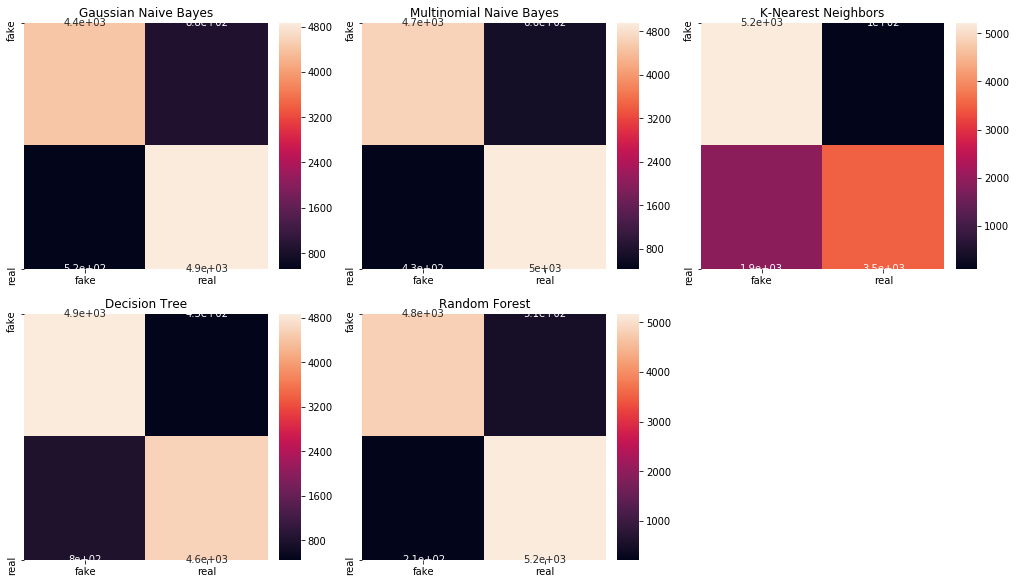

In [63]:
# set basic figure parameters
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), constrained_layout=True)

# change the labels
x_axis_labels = ["fake", "real"]
y_axis_labels = ["fake", "real"]

# plot the heatmaps
sn.heatmap(gnb_cm, annot=True, ax=axes[0,0], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sn.heatmap(mnb_cm, annot=True, ax=axes[0,1], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sn.heatmap(knn_cm, annot=True, ax=axes[0,2], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sn.heatmap(dt_cm, annot=True, ax=axes[1,0], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sn.heatmap(rf_cm, annot=True, ax=axes[1,1], xticklabels=x_axis_labels, yticklabels=y_axis_labels)

# hide the 6th plot
axes[1,2].axis('off')

# add titles
axes[0,0].set_title('Gaussian Naive Bayes')
axes[0,1].set_title('Multinomial Naive Bayes')
axes[0,2].set_title('K-Nearest Neighbors')
axes[1,0].set_title('Decision Tree')
axes[1,1].set_title('Random Forest')

# save and the figure
plt.savefig(figure_path + "confusion_matrixes_raw.png", dpi=100)

## Metric comparisons

In [47]:
# define function to convert the metrics dictionary to a list for plotting  
def convert_dict_results(results_dictionary): 
  
  # make an empty list to store results
  results_list = []
  
  # add the converted results
  results_list.append(results_dictionary['fake']['precision'])
  results_list.append(results_dictionary['real']['precision'])
  results_list.append(results_dictionary['fake']['recall'])
  results_list.append(results_dictionary['real']['recall'])
  results_list.append(results_dictionary['fake']['f1-score'])
  results_list.append(results_dictionary['real']['f1-score'])
  results_list.append(results_dictionary['accuracy'])

  # return the converted list
  return(results_list)

In [48]:
# define a function to get the relative processing time for each model
def get_relative_processing_time(model):

  # make a list of the processing time
  model_time_list = [gnb_model_time, mnb_model_time, knn_model_time, dt_model_time, rf_model_time]

  # get the maximum time
  max_model_time = max(model_time_list)

  return(model/max_model_time)

rel_gnb_model_time = get_relative_processing_time(gnb_model_time)
rel_mnb_model_time = get_relative_processing_time(mnb_model_time)
rel_knn_model_time = get_relative_processing_time(knn_model_time)
rel_dt_model_time = get_relative_processing_time(dt_model_time)
rel_rf_model_time = get_relative_processing_time(rf_model_time)

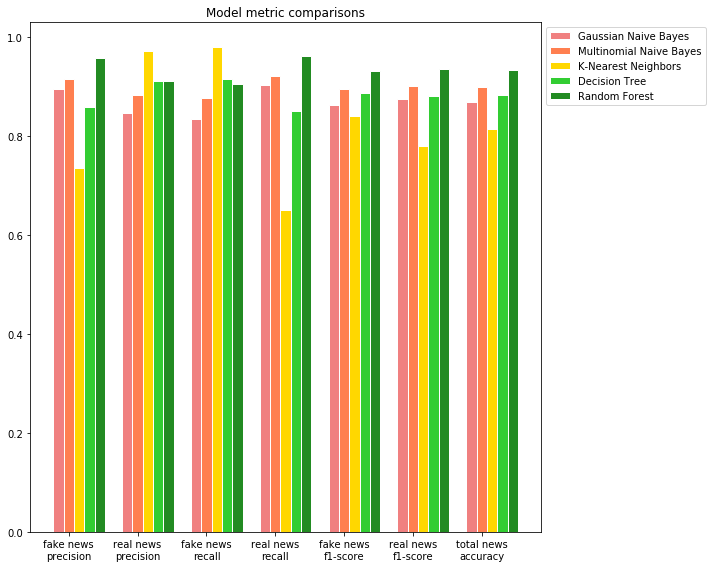

In [49]:
# set general figure parameters
fig = plt.figure(figsize=(10, 8), tight_layout=True)

# set the title
plt.title("Model metric comparisons")

# set the width of each bar
barWidth = 0.15

# set the x-axis labels
metrics = ['fake news\nprecision',
           'real news\nprecision', 
           'fake news\nrecall',
           'real news\nrecall', 
           'fake news\nf1-score',  
           'real news\nf1-score', 
           'total news\naccuracy']

# get the heights of all the bars from the dictionary results, add the proccesing time          
gnb_bar = convert_dict_results(gnb_dict_results)
mnb_bar = convert_dict_results(mnb_dict_results)
knn_bar = convert_dict_results(knn_dict_results)
dt_bar = convert_dict_results(dt_dict_results)
rf_bar = convert_dict_results(rf_dict_results)

# set position of bar on X axis
bar_x1 = np.arange(len(gnb_bar))
bar_x2 = [x + barWidth for x in bar_x1]
bar_x3 = [x + barWidth for x in bar_x2]
bar_x4 = [x + barWidth for x in bar_x3]
bar_x5 = [x + barWidth for x in bar_x4]

# plot each bar
plt.bar(bar_x1, gnb_bar, color='lightcoral', width=barWidth, edgecolor='white', label='Gaussian Naive Bayes')
plt.bar(bar_x2, mnb_bar, color='coral', width=barWidth, edgecolor='white', label='Multinomial Naive Bayes')
plt.bar(bar_x3, knn_bar, color='gold', width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
plt.bar(bar_x4, dt_bar, color='limegreen', width=barWidth, edgecolor='white', label='Decision Tree')
plt.bar(bar_x5, rf_bar, color='forestgreen', width=barWidth, edgecolor='white', label='Random Forest')

# set the x-axis spacing and labels
plt.xticks([r + barWidth for r in range(len(gnb_bar))], metrics)

# show the legend and figure, save
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(figure_path + "metric_comparison.png", dpi=100)
plt.show()

## Processing time

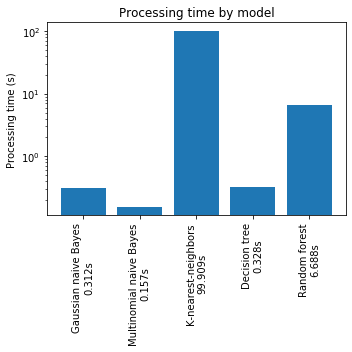

In [50]:
# set up the general figure
fig = plt.figure(figsize=(5,5), tight_layout=True)

# make lists to plot
processing_time_list = [gnb_model_time,
                        mnb_model_time,
                        knn_model_time,
                        dt_model_time,
                        rf_model_time]
label_list = ["Gaussian naive Bayes\n{}s".format(gnb_model_time),
              "Multinomial naive Bayes\n{}s".format(mnb_model_time),
              "K-nearest-neighbors\n{}s".format(knn_model_time),
              "Decision tree\n{}s".format(dt_model_time),
              "Random forest\n{}s".format(rf_model_time)]


# plot the features and scores
plt.bar(label_list, processing_time_list)

# set the title and axes
plt.title("Processing time by model")
plt.ylabel("Processing time (s)")
plt.yscale('log')
plt.xticks(rotation=90)

# show the legend and figure, save
plt.savefig(figure_path + "model_processing_time.png", dpi=100)
plt.show()

# V. Explore models

In [51]:
# define a function to print important features
def get_feature_importance(model, num_of_features):

  # get a list of all the TFIDF keywords
  keyword_list_all = list(all_text_vectors_df.loc[:, all_text_vectors_df.columns != 'classification_label'].columns)

  # make empty lists to store results
  keyword_list = []

  # get the model importance scores
  model_importance = model.feature_importances_

  # loop through all the features and scores
  for feature, score in enumerate(model_importance):

      # append the keyword and score
      keyword_list.append([keyword_list_all[feature], round(score, 2)])

  # sort the list of lists by score to get the most important features
  keyword_list = sorted(keyword_list, key=operator.itemgetter(1), reverse=True)

  # abbreviate the keyword list 
  keyword_list = keyword_list[:num_of_features]

  # make empty strings to store the return values
  feature_list = []
  score_list = []

  # get the features and scores to return
  for keyword_score_pair in keyword_list:

    # add the values from each pair
    feature_list.append(keyword_score_pair[0])
    score_list.append(keyword_score_pair[1])


  # return the lists
  return(feature_list, score_list)

## Explore decision tree

### Feature importance

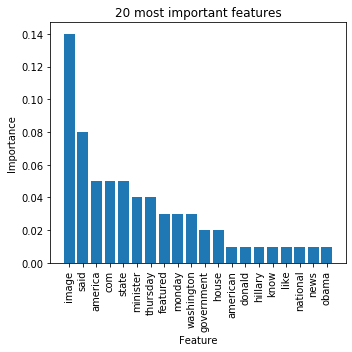

In [52]:
# get importance
num_features = 20
dt_features, dt_scores = get_feature_importance(dt_model, num_features)

# set up the general figure
fig = plt.figure(figsize=(5,5), tight_layout=True)

# plot the features and scores
plt.bar(dt_features, dt_scores)

# set the title and axes
plt.title("{} most important features".format(len(dt_features)))
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=90)

# show the legend and figure, save
plt.savefig(figure_path + "feature_importance_dt.png", dpi=100)
plt.show()

### Tree diagram

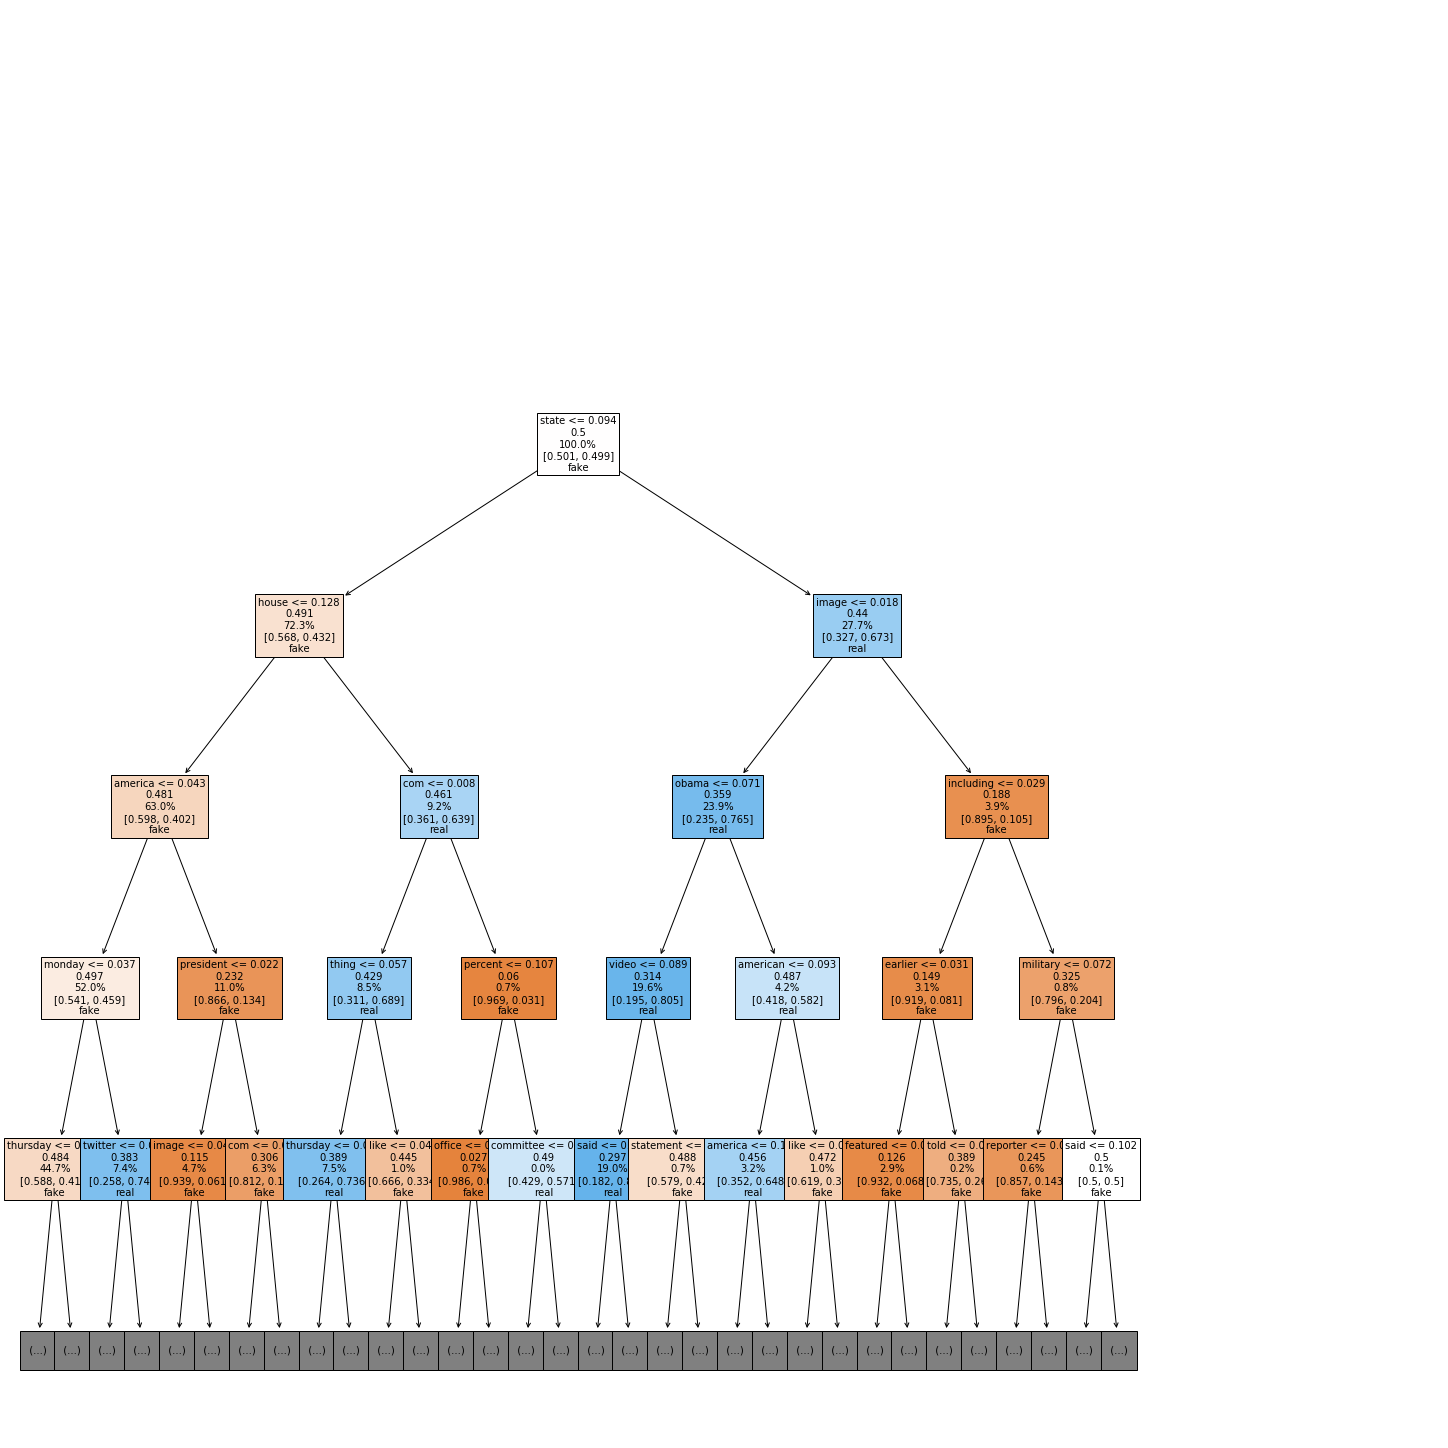

In [65]:
# set up the general figure (must be giant to show detail)
fig = plt.figure(figsize=(20,20), constrained_layout=True)

# get a list of all the keywords
keywords = list(all_text_vectors_df.loc[:, all_text_vectors_df.columns != 'classification_label'].columns)

# plot the tree, setting the depth
plot_tree(dt_model, 
          max_depth=3, 
          feature_names=keywords, 
          class_names=["fake", "real"], 
          filled=True, 
          label=None, 
          proportion=True, 
          fontsize=10)

# save the tree figure
plt.savefig(figure_path + "decision_tree_depth3.png", dpi=100)

## Explore random forest

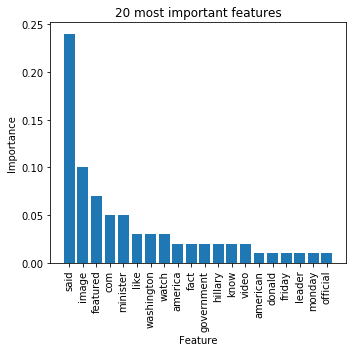

In [54]:
# get importance
num_features = 20
rf_features, rf_scores = get_feature_importance(rf_model, num_features)

# set up the general figure
fig = plt.figure(figsize=(5,5), tight_layout=True)

# plot the features and scores
plt.bar(rf_features, rf_scores)

# set the title and axes
plt.title("{} most important features".format(len(dt_features)))
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=90)

# show the legend and figure, save
plt.savefig(figure_path + "feature_importance_rf.png", dpi=100)
plt.show()

## Feature comparison

In [55]:
# write a function to generate histogram comparison plots
def make_histogram_comparison(keyword):

  # set up the general figure
  fig = plt.figure(figsize=(6,4), tight_layout=True)

  # get histogram series of keyword values
  real_keyword = all_text_vectors_df[keyword].loc[(all_text_vectors_df['classification_label'] == "real")]
  fake_keyword = all_text_vectors_df[keyword].loc[(all_text_vectors_df['classification_label'] == "fake")]

  # plot both histograms
  plt.hist(real_keyword, bins=20, density='true', histtype='step', color="green", label="in real news")
  plt.hist(fake_keyword, bins=20, density='true', histtype='step', color="red", label="in fake news")

  # set the axes
  plt.yscale('log')
  plt.ylabel("Relative frequency of score")
  plt.xlabel("TFIDF values of '{}'".format(keyword))

  # show the legend, title, and figure, save
  plt.legend(bbox_to_anchor=(0.65, 0.82))
  plt.title("Feature importance of: '{}'".format(keyword))
  plt.savefig(figure_path + "/features/" + "feature_importance_{}.png".format(keyword), dpi=100)
  plt.show()

### Generate histograms

In [57]:
# get a set of all the important words
all_features = set(dt_features + rf_features)

# loop through each word
for feature in all_features:

  # genereate and save a plot for each one
  make_histogram_comparison(feature)

  # clear the plot
  clear_output()

## Drop important features

### Modify the data

In [ ]:
# drop "said" from the dataframe
all_text_vectors_df = all_text_vectors_df.drop("said", "columns")

# split into train and test
text_vectors_train, text_vectors_test, label_train, label_test = train_test_split(all_text_vectors_df.loc[:, all_text_vectors_df.columns != 'classification_label'], 
                                                                                  all_text_vectors_df['classification_label'], test_size=0.25, random_state=42)

### Re-apply the DT classifier

In [ ]:
# load the saved optimum hyperparameters
file = open(data_path + 'dt_optimum_parameters.txt', "r")
contents = file.read()

# convert the string to a dictionary
dt_parameters = ast.literal_eval(contents)
file.close()

# mark the start time
start_time = time.time()

# initialize the dt model
dt_model = DecisionTreeClassifier(max_depth=dt_parameters['max_depth'],
                                  min_samples_leaf=dt_parameters['min_samples_leaf'],
                                  max_features=dt_parameters['max_features'])

# fit the model to the training data
dt_model.fit(text_vectors_train, label_train)

# apply the model to the test data
dt_model_predict = dt_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
dt_model_time = round(end_time - start_time, 3)

# get the results
dt_results = classification_report(label_test, dt_model_predict)
dt_dict_results = classification_report(label_test, dt_model_predict, output_dict=True)

# print the results and parameters
print(dt_parameters)
print(str(gnb_model_time) + "s to process")
print(dt_results)

### Re-apply the RF classifier

In [ ]:
# load the saved optimum hyperparameters
file = open(data_path + 'rf_optimum_parameters.txt', "r")
contents = file.read()

# convert the string to a dictionary
rf_parameters = ast.literal_eval(contents)
file.close()

# mark the start time
start_time = time.time()

# initialize the rf model
rf_model = RandomForestClassifier(n_estimators=rf_parameters['n_estimators'], 
                                  max_depth=rf_parameters['max_depth'],
                                  min_samples_leaf=rf_parameters['min_samples_leaf'],
                                  max_features=rf_parameters['max_features'])

# fit the model to the training data
rf_model.fit(text_vectors_train, label_train)

# apply the model to the test data
rf_model_predict = rf_model.predict(text_vectors_test)

# mark the end time
end_time = time.time()

# save the time elapsed
rf_model_time = round(end_time - start_time, 3)

# get the results
rf_results = classification_report(label_test, rf_model_predict)
rf_dict_results = classification_report(label_test, rf_model_predict, output_dict=True)

# print the results and parameters
print(rf_parameters)
print(str(rf_model_time) + "s to process")
print(rf_results)